---
license:
    code: MIT
    content: CC-BY-4.0
github: https://github.com/ocademy-ai/machine-learning
venue: By Ocademy
open_access: true
bibliography:
  - https://raw.githubusercontent.com/ocademy-ai/machine-learning/main/open-machine-learning-jupyter-book/references.bib
---

# Transformers for Language Modelling

As we have familiarized ourselves with the attention mechanism in Transformers, now let's see how these models can be trained as language models.

* In the first part, I prepared a few pretrained language models for you to examine and play with.
* In the second part, we will train a transformer language model from scratch.
  * We will handcraft a simple English language with [Probabilistic Context free Grammar](https://en.wikipedia.org/wiki/Probabilistic_context-free_grammar).
  * Then let the GPT learn this artificial language, and we will examine the emergent phenomena from training.


## Play with Pre-trained transformers language models

`transformers` library from huggingface is the *de facto* standard library for loading and using transformer architectures.

Let's load some common models and see their inner architecture. Specifically, we will look at two classic models, BERT and GPT2. (developped ~ 2018)

They are both transformers but with some prominal differences

* BERT: Bidirectional Encoder Representations from Transformers
  * **Architecture**: All-to-all attention. Transformer Encoder.
  * **Objective**: Masked language modelling
  * **Usage**:
    * Can fill in blanks and perform cloze task
    * Provide representation for many downstream language understanding tasks.
* GPT2: Generative Pre-trained Transformer 2
  * **Architecture**: Causal attention. Transformer Decoder
  * **Objective**: autoregressive language modelling
  * **Usage**:
    * Can continue prompt and answer questions
    * Can be finetuned to follow task specific instructions.


Here are the conceptual picture of BERT and GPT2, let's keep it in mind and try to map them to the modules we see

**BERT**

![BERT (Transformer encoder)](https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/llm/clipboard_20240409_034503.png)

**GPT2**

![](https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/llm/clipboard_20240409_034531.png)

### Loading

In [1]:
import transformers
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config, GPT2LMHeadModel, DataCollatorForLanguageModeling
from transformers import pipeline, BertModel, BertConfig, BertTokenizer, BertLMHeadModel

In [2]:
import torch
import torch.nn as nn
def recursive_print(module, prefix="", depth=0, deepest=3):
    """Simulating print(module) for torch.nn.Modules
        but with depth control. Print to the `deepest` level. `deepest=0` means no print
    """
    if depth == 0:
        print(f"[{type(module).__name__}]")
    if depth >= deepest:
        return
    for name, child in module.named_children():
        if len([*child.named_children()]) == 0:
            print(f"{prefix}({name}): {child}")
        else:
            if isinstance(child, nn.ModuleList):
                print(f"{prefix}({name}): {type(child).__name__} len={len(child)}")
            else:
                print(f"{prefix}({name}): {type(child).__name__}")
        recursive_print(child, prefix + "  ", depth + 1, deepest)

### BERT

In [3]:
# Accessing the model configuration
BERTtokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
BERTmodel = BertModel.from_pretrained('bert-base-uncased')
BERTconfig = BERTmodel.config

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [4]:
BERTconfig

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.39.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

### Let BERT do a cloze test

In [5]:
unmasker = pipeline('fill-mask', model='bert-base-uncased')
unmasker("Hello I'm a [MASK] model.")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.10731107741594315,
  'token': 4827,
  'token_str': 'fashion',
  'sequence': "hello i'm a fashion model."},
 {'score': 0.08774460107088089,
  'token': 2535,
  'token_str': 'role',
  'sequence': "hello i'm a role model."},
 {'score': 0.05338377505540848,
  'token': 2047,
  'token_str': 'new',
  'sequence': "hello i'm a new model."},
 {'score': 0.04667223244905472,
  'token': 3565,
  'token_str': 'super',
  'sequence': "hello i'm a super model."},
 {'score': 0.027095822617411613,
  'token': 2986,
  'token_str': 'fine',
  'sequence': "hello i'm a fine model."}]

### Inner structure of BERT

In [6]:
recursive_print(BERTmodel,deepest=1)

[BertModel]
(embeddings): BertEmbeddings
(encoder): BertEncoder
(pooler): BertPooler


In [7]:
recursive_print(BERTmodel.encoder,deepest=2)

[BertEncoder]
(layer): ModuleList len=12
  (0): BertLayer
  (1): BertLayer
  (2): BertLayer
  (3): BertLayer
  (4): BertLayer
  (5): BertLayer
  (6): BertLayer
  (7): BertLayer
  (8): BertLayer
  (9): BertLayer
  (10): BertLayer
  (11): BertLayer


In [8]:
recursive_print(BERTmodel.encoder.layer[0],deepest=2)

[BertLayer]
(attention): BertAttention
  (self): BertSelfAttention
  (output): BertSelfOutput
(intermediate): BertIntermediate
  (dense): Linear(in_features=768, out_features=3072, bias=True)
  (intermediate_act_fn): GELUActivation()
(output): BertOutput
  (dense): Linear(in_features=3072, out_features=768, bias=True)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)


In [9]:
recursive_print(BERTmodel.encoder.layer[0].attention,deepest=2)

[BertAttention]
(self): BertSelfAttention
  (query): Linear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
(output): BertSelfOutput
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)


### GPT2

In [10]:
GPTtokenizer = GPT2Tokenizer.from_pretrained('gpt2')
GPTmodel  = GPT2Model.from_pretrained('gpt2')
GPTconfig = GPT2Config.from_pretrained('gpt2')

In [11]:
GPTconfig

GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.39.3",
  "use_cache": true,
  "vocab_size": 50257
}

### Let GPT say something

In [12]:
GPTLMmodel = GPT2LMHeadModel.from_pretrained('gpt2')

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [13]:
input_ids = GPTtokenizer.encode("The meaning of life")
out_ids = GPTLMmodel.generate(torch.tensor(input_ids).long()[None,:],
              max_length=32, do_sample=True, top_k=0, top_p=0.9, temperature=0.7,
              num_return_sequences=5,)
for seq in out_ids:
  print(GPTtokenizer.decode(seq))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The meaning of life is a matter of faith, but it is also a matter of love. God is a good person, but not a good God. If
The meaning of life as we know it is an eternal struggle between the two. We are both members of the same family. We both live in a world where
The meaning of life in this world is so far removed from the human condition that it is hard to know what to make of it. The question is: How
The meaning of life is life-giving and life is life. That is why God gives us life. And this is why God gives us life.


The meaning of life is not simply the act of maintaining it, but the act of preserving it. It is the act of keeping it, of maintaining it,


### Inner structure of GPTmodel

In [14]:
recursive_print(GPTmodel,deepest=1)

[GPT2Model]
(wte): Embedding(50257, 768)
(wpe): Embedding(1024, 768)
(drop): Dropout(p=0.1, inplace=False)
(h): ModuleList len=12
(ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)


In [15]:
recursive_print(GPTmodel.h,deepest=1)

[ModuleList]
(0): GPT2Block
(1): GPT2Block
(2): GPT2Block
(3): GPT2Block
(4): GPT2Block
(5): GPT2Block
(6): GPT2Block
(7): GPT2Block
(8): GPT2Block
(9): GPT2Block
(10): GPT2Block
(11): GPT2Block


In [16]:
recursive_print(GPTmodel.h[0],deepest=1)

[GPT2Block]
(ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
(attn): GPT2Attention
(ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
(mlp): GPT2MLP


In [17]:
recursive_print(GPTmodel.h[0].attn,deepest=2)

[GPT2Attention]
(c_attn): Conv1D()
(c_proj): Conv1D()
(attn_dropout): Dropout(p=0.1, inplace=False)
(resid_dropout): Dropout(p=0.1, inplace=False)


In [18]:
recursive_print(GPTmodel.h[0].mlp,deepest=2)

[GPT2MLP]
(c_fc): Conv1D()
(c_proj): Conv1D()
(act): NewGELUActivation()
(dropout): Dropout(p=0.1, inplace=False)


## Train a transformer to "speak your own language"!

So let's design an artificial language with simple grammar and let the transformer learn to "speak" it. More technically, this means, we hand-craft a probabilistic model of language (sequence) and then let the transformer learn it.

### Probabilistic Generative Grammar

First let's make our *simplified English grammar*.

By building a set of probabilistic generative grammar, or more technically, [Probabilistic context-free grammar, (PCFG)](https://en.wikipedia.org/wiki/Probabilistic_context-free_grammar)

This language has these part of speeches
* Noun
* Intransitive verb
* Transitive verb
* Article
* Adjective
* Conjunction "that"



In [19]:
#%% list of words and their parts of speech
# nouns
noun_list = ["cat", "dog", "fox", "bird", "horse", "sheep", "cow", "bear", "zebra", "giraffe"]
# intransitive verb
intrans_verb_list = ["ran", "jumped", "swam", "flew", "walked", "slept", "sat", "stood", "danced"]
# transitive verbs that took an object or a clause
trans_verbs_list = ["saw", "heard", "smelled", ]
# adjectives
adj_list = ["big", "small", "tall", "short", "long", "wide", "fat", "thin", "round", "square", "smart", "pretty"]
# adverbs
article_list = ["the", "a"]
# conjunctive that introduces a clause.
conjunction_list = ["that"]

This language also has the following grammar, i.e. a set of substitution rules. For example,

$$S\to NP,VP$$
means a sentence can be substituted by a Noun phrase (NP) + a Verb phrase (VP).
$$VP\to TV, Conj, NP, VP$$
means a verb phrase can be substituted by a transitive verb (TV) + a conjunction (Conj) + a Noun phrase (NP) + a Verb phrase (VP).

The full set of rules are following, feel free to modify it!

In [20]:
# Rules for mapping part of speech to words
word_map = {
    "N": noun_list,
    "IV": intrans_verb_list,
    "TV": trans_verbs_list,
    "Adj": adj_list,
    "Article": article_list,
    "Conj": conjunction_list,
}
# Grammar for generating sentences
rules = {
    # sentence
    "S": [["NP", "VP"]],
    # noun phrase
    "NP": [["Article", "N"],
           ["Article", "Adj", "N"],
           ["Article", "Adj", "Adj", "N"],
           ["Article", "N", "Conj", "IV"]],
    # verb phrase
    "VP": [["IV"],
           ["TV", "NP"],
           ["TV", "Conj", "NP", "VP"], ],
}

### Sample from probabilistic generative grammar

Now, see what these rules can generate using **probabilistic generative grammar**, i.e. recursively applying the substitution rules to an initial token $S$ to elaborate it.


In [21]:
import random
def generate_sentences(rules, word_map, max_depth=3, show=False):
    """ A sentence generator with probabilistic generative grammar. """
    initial_token = "S"
    sentence = [initial_token]
    depth = 0
    while True:
        next_sentence = []
        fully_expanded = True
        for token in sentence:
            if token in rules:
                # expand the phrase
                if depth < max_depth:
                    next_sentence.extend(random.choice(rules[token]))
                else:
                    # to limit complexity, we stop adding clauses
                    next_sentence.extend(random.choice(rules[token][:-1]))  # don't expand into the last conjunctive rule

                fully_expanded = False
            else:
                next_sentence.append(token)

        sentence = next_sentence
        depth += 1
        if show:
            print(sentence)
        if fully_expanded:
            break
    # turn tokens into words
    verbal_sentence = []
    for token in sentence:
        word = random.choice(word_map[token])
        verbal_sentence.append(word)
    sent_str = " ".join(verbal_sentence)
    return verbal_sentence, sent_str


word_seq, sentence_str = generate_sentences(rules, word_map, show=True, max_depth=5)
print(sentence_str)

['NP', 'VP']
['Article', 'N', 'Conj', 'IV', 'TV', 'Conj', 'NP', 'VP']
['Article', 'N', 'Conj', 'IV', 'TV', 'Conj', 'Article', 'N', 'TV', 'NP']
['Article', 'N', 'Conj', 'IV', 'TV', 'Conj', 'Article', 'N', 'TV', 'Article', 'N', 'Conj', 'IV']
['Article', 'N', 'Conj', 'IV', 'TV', 'Conj', 'Article', 'N', 'TV', 'Article', 'N', 'Conj', 'IV']
a cat that slept smelled that the zebra smelled the giraffe that ran


Surely you can generate all kinds of nonsensical sentences which are grammatically correct!
> a small big cow smelled the thin fat zebra

But let's ignore it for a moment and let a transformer learn to "speak" this simply English.

### Tokenization: map words to numbers

For a computational system to understand language, first, we need to break the sentence into words and turn the words into something they know , indices. This is known as tokenization and encoding.

In [22]:
full_word_set = set(sum([words for words in word_map.values()], []))
dictionary = {word: i for i, word in enumerate(full_word_set)}  # Mapping words to indices
dictionary["[End]"] = len(dictionary)
EOS_ID = dictionary["[End]"]  # end of sentence token
PAD_ID = len(dictionary)  # padding token
dictionary[""] = PAD_ID

inverse_dictionary = {i: word for word, i in dictionary.items()}   # Mapping indices to words

In [23]:
def tokenize_sentence(sentence):
    """ Tokenize a sentence into a list of words. """
    word_seq = sentence.split(" ")
    return word_seq


def encode_sentence(sentence):
    """ Encode a sentence into a list of indices. """
    word_seq = tokenize_sentence(sentence)
    inds = encode2indices(word_seq)
    return inds


def encode2indices(word_seq):
    """ Encode a list of words into a list of indices. """
    inds = [dictionary[word] for word in word_seq]
    return inds


def decode2words(indices):
    """ Decode a list of indices into a list of words. """
    words = [inverse_dictionary[ind] for ind in indices]
    return words


def decode2sentence(indices):
    """ Decode a list of indices into a sentence. """
    words = decode2words(indices)
    sentence = " ".join(words)
    return sentence

In [24]:
encode_sentence("a smart fox saw a cat that ran")

[2, 3, 1, 26, 2, 10, 30, 19]

### Build Sequence Dataset: `pad_seq` etc.

Since we don't have a fixed dataset, but a generative model of language, we can simply generate new sentences on the fly and fed it to our transformer. (this is usually not the case)

In [25]:
import torch
from torch.nn.utils.rnn import pad_sequence

def batch_sampler(batch_size=32, max_len=128):
    batch = []
    for i in range(batch_size):
        word_seq, _ = generate_sentences(rules, word_map)
        word_seq.append("[End]")  # add this marker to say, the sentence has ended.
        inds = encode2indices(word_seq)
        batch.append(torch.tensor(inds, dtype=torch.long))
    # pad the batch to be equal length, same len as the longest senetence.
    padded_batch = pad_sequence(batch, batch_first=True, padding_value=PAD_ID)
    # chuck to the max_len
    padded_batch = padded_batch[:, :max_len]
    return padded_batch

In [26]:
batch = batch_sampler()
print(batch.shape)
for j in range(batch.shape[0]):
    print(decode2sentence(batch[j].tolist()))

torch.Size([32, 20])
the cat that sat heard that the cat that sat smelled that the bird saw a sheep [End]  
a dog swam [End]                
a bird that swam heard that a giraffe smelled a fat horse [End]       
a short smart dog saw that the sheep that stood saw that a bear sat [End]    
the round cat swam [End]               
the thin cow smelled a zebra that slept [End]           
a bird heard that a cow saw a smart thin zebra [End]        
a dog jumped [End]                
a horse smelled that a cat danced [End]            
the small dog saw that a wide bear smelled that the long sheep slept [End]     
a thin thin cat slept [End]              
a thin zebra saw the wide zebra [End]            
the dog saw a big pretty cat [End]            
the dog sat [End]                
the small smart bear danced [End]              
the horse that flew sat [End]              
the sheep that stood smelled the sheep that jumped [End]          
a long wide bird saw a zebra [End]            
a zebr

### Train a transformer on this language

In [27]:
import torch
from torch.optim import AdamW
from transformers import GPT2Model, GPT2Tokenizer, GPT2LMHeadModel, GPT2Config

In [28]:
miniGPTconfig = GPT2Config(vocab_size=len(dictionary), n_positions=128, n_ctx=128,
                           n_embd=64, n_layer=3, n_head=8,
                           eos_token_id=EOS_ID, pad_token_id=PAD_ID)
miniGPT = GPT2LMHeadModel(miniGPTconfig, )

Finally, let's run our training loops!

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_curve = []
optimizer = AdamW(miniGPT.parameters(), lr=5e-4)
miniGPT.train()
miniGPT.to(device)
batch_size = 512
for epoch in range(3):
    for i in range(50):
        batch = batch_sampler(batch_size=batch_size)
        output = miniGPT(batch.to(device), labels=batch.to(device), )
        loss = output.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"epoch {epoch}, batch {i}, loss {loss.item()}")
        loss_curve.append(loss.item())


miniGPT.eval().to("cpu")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


epoch 0, batch 0, loss 3.2727038860321045
epoch 0, batch 1, loss 3.013523817062378
epoch 0, batch 2, loss 2.9508156776428223
epoch 0, batch 3, loss 2.864698648452759
epoch 0, batch 4, loss 2.8440003395080566
epoch 0, batch 5, loss 2.792489528656006
epoch 0, batch 6, loss 2.7530574798583984
epoch 0, batch 7, loss 2.712508201599121
epoch 0, batch 8, loss 2.7014684677124023
epoch 0, batch 9, loss 2.6464850902557373
epoch 0, batch 10, loss 2.6130788326263428
epoch 0, batch 11, loss 2.6004862785339355
epoch 0, batch 12, loss 2.5547451972961426
epoch 0, batch 13, loss 2.492750883102417
epoch 0, batch 14, loss 2.4694128036499023
epoch 0, batch 15, loss 2.4235713481903076
epoch 0, batch 16, loss 2.3857686519622803
epoch 0, batch 17, loss 2.4006121158599854
epoch 0, batch 18, loss 2.3581535816192627
epoch 0, batch 19, loss 2.2853527069091797
epoch 0, batch 20, loss 2.2719969749450684
epoch 0, batch 21, loss 2.2839810848236084
epoch 0, batch 22, loss 2.259561061859131
epoch 0, batch 23, loss 2.1

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(39, 64)
    (wpe): Embedding(128, 64)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-2): 3 x GPT2Block(
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=64, out_features=39, bias=False)
)

### Say Something? (or I'm Giving Up On You)

In [30]:
prompt = "the dog"
prompt_inds = encode_sentence(prompt)
ind_tsr = miniGPT.generate(torch.tensor(prompt_inds).long()[None, :],
                           max_length=32, do_sample=True, top_k=0, top_p=0.9, temperature=0.7,
                           num_return_sequences=5, pad_token_id=PAD_ID)
for ind_seq in ind_tsr:
    print(decode2sentence(ind_seq.tolist()))

the dog that heard that a bird that the square fox flew [End]     
the dog saw a zebra [End]            
the dog that slept flew [End]            
the dog that walked saw that the sheep that danced saw that the smart smart giraffe swam [End]
the dog that sat saw that a fat fat sheep smelled that the thin square cow swam [End]


### Does our transformer "understand" part-of-speech?

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

First, let's extract the embeddings of the words and the positions

In [32]:
token_embedding = miniGPT.transformer.wte.weight.detach()
position_embedding = miniGPT.transformer.wpe.weight.detach()
print(token_embedding.shape)
print(position_embedding.shape)

torch.Size([39, 64])
torch.Size([128, 64])


We'd want to see how these learned embeddings cluster.

In [33]:
tsne = TSNE(n_components=2, random_state=0, perplexity=15.0)
token_embedding_2d = tsne.fit_transform(token_embedding.numpy())
kmeans = KMeans(n_clusters=6, random_state=0).fit(token_embedding_2d)

d:\app\anaconda3\envs\open-machine-learning-jupyter-book\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


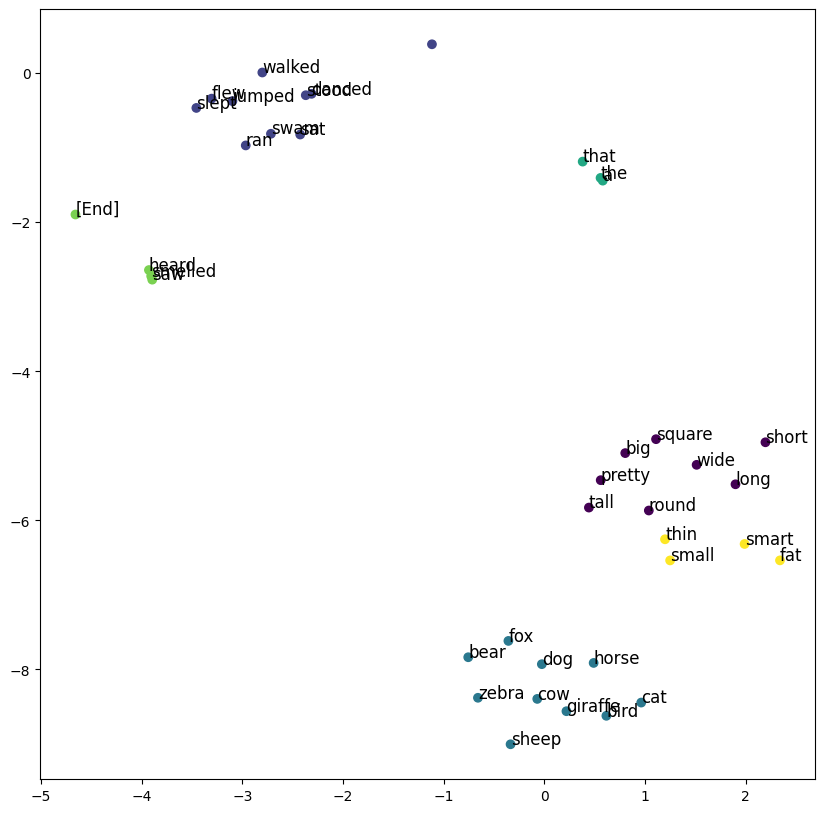

In [34]:
plt.figure(figsize=[10, 10])
plt.scatter(token_embedding_2d[:, 0], token_embedding_2d[:, 1], c=kmeans.labels_)
# annotate each word on the plot
for i, word in enumerate(inverse_dictionary.values()):
    plt.annotate(word, (token_embedding_2d[i, 0], token_embedding_2d[i, 1]), fontsize=12)
plt.show()

Let's print out which words are in each cluster.

In [35]:
nCluster = 7
kmeans2 = KMeans(n_clusters=nCluster, random_state=42).fit(token_embedding.numpy())
# print the list of words in each cluster
for icluster in range(nCluster):
    cluster_words = [word for word, ind in dictionary.items() if kmeans2.labels_[ind] == icluster]
    print(f"cluster {icluster}: {cluster_words}")


cluster 0: ['smelled', 'saw', 'heard']
cluster 1: ['wide', 'fox', 'smart', 'small', 'tall', 'bird', 'short', 'cat', 'sheep', 'bear', 'cow', 'horse', 'giraffe', 'round', 'dog', 'big', 'zebra', 'square', 'thin', 'fat', 'pretty', 'long']
cluster 2: ['jumped', 'danced', 'walked', 'ran', 'stood', 'sat', 'swam', 'flew', 'slept']
cluster 3: ['[End]']
cluster 4: ['a', 'the']
cluster 5: ['']
cluster 6: ['that']


d:\app\anaconda3\envs\open-machine-learning-jupyter-book\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Overall birds eye view of the word representations (embeddings)

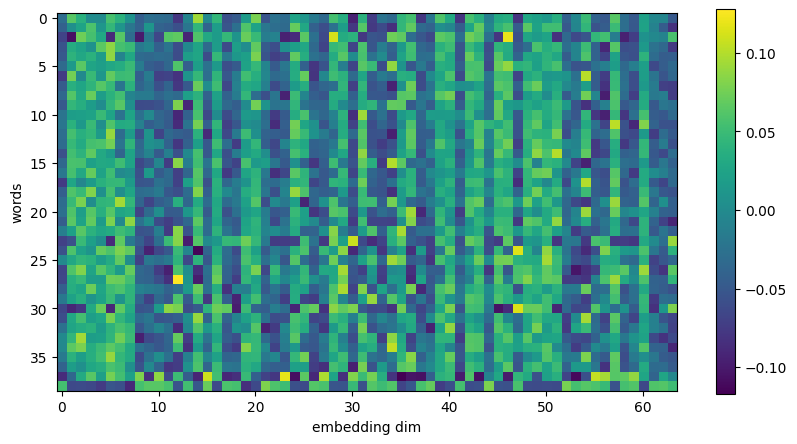

In [36]:
plt.figure(figsize=[10,5])
plt.imshow(token_embedding)
plt.ylabel("words")
plt.xlabel("embedding dim")
plt.colorbar()
plt.show()

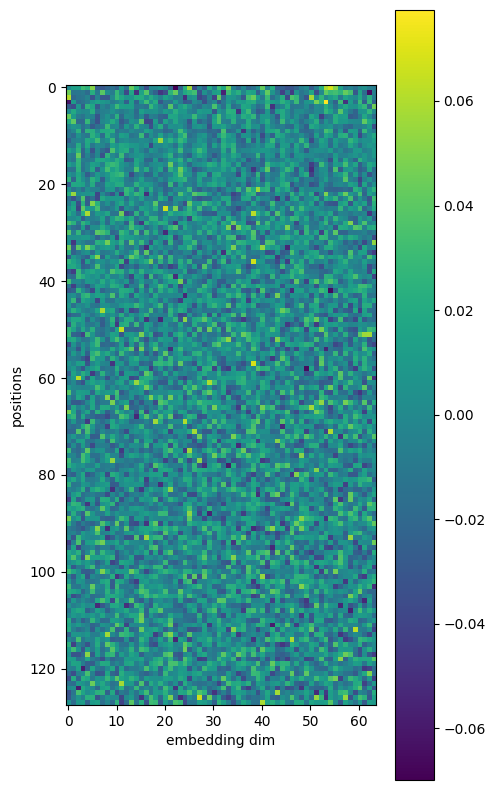

In [37]:
plt.figure(figsize=[5,10])
plt.imshow(position_embedding)
plt.ylabel("positions")
plt.xlabel("embedding dim")
plt.colorbar()
plt.show()

## Your turn! 🚀
tbd.

## Acknowledgments

Thanks to [Binxu Wang](https://github.com/Animadversio) for creating the open-source course [From Transformer to LLM: Architecture, Training and Usage](https://github.com/Animadversio/TransformerFromScratch). It inspires the majority of the content in this chapter.